In [1]:

# !wget -q https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/braintumors_coco.zip
# !unzip -q braintumors_coco.zip

# Register datasets 

In [2]:
from detectron2.utils.logger import setup_logger 
logger = setup_logger()

In [3]:
from detectron2.data.datasets import register_coco_instances

In [4]:
#Some configurations 
name_ds = "braintumors_coco"
name_ds_train = name_ds + "_train"
image_root_train = name_ds +"/train"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af 

In [5]:
#Register the dataset 
### Train dataset 
register_coco_instances(
    name = name_ds_train,
    metadata={},
    json_file = json_file_train,
    image_root = image_root_train
)

# Training configuration 

In [6]:
import os 
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle

In [7]:
output_dir = "output/object_detector_hook"
os.makedirs(output_dir,exist_ok=True)
output_cfg_path = os.path.join(output_dir,"cfg.pickle")
nc = 2
device = "cuda"
### Select a model 
config_file_url = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"

In [8]:
#Create a configuration file 
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS  = model_zoo.get_checkpoint_url(checkpoint_url)
# Set datasets
cfg.DATASETS.TRAIN  = (name_ds_train)
cfg.DATALOADER.NUM_WORKERS = nc
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 5000 
cfg.SOLVER.CHECKPOINT_PERIOD = 500 
cfg.TEST.EVAL_PERIOD  = cfg.SOLVER.CHECKPOINT_PERIOD 

cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc 
cfg.MODEL.DEVICE  = device 
cfg.OUTPUT_DIR = output_dir   

In [9]:
from detectron2.engine import DefaultTrainer
trainer = DefaultTrainer(cfg)

[04/26 00:32:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# Preprocessing Input images 

In [10]:
print("MIN_SIZE_TRAIN",cfg.INPUT.MIN_SIZE_TRAIN)
print("MAX_SIZE_TRAIN",cfg.INPUT.MAX_SIZE_TRAIN)

MIN_SIZE_TRAIN (640, 672, 704, 736, 768, 800)
MAX_SIZE_TRAIN 1333


- The ResizeShortestEdge method uses these hyperparameters to resize input images.Precisley, it resizes shorter edges to one random value selected from MIN_SIZE_TRAIN as long as the longer edges are smaller than MAX_SIZE_TRAIN. 
- otherwise,it continues to resize the longer edges to MAX_SIZE_TEAIN
- while resizing, the image aspect ratio remains the same,The following code samples for one training batch and displays the sizes of the sampled/transformed images 

In [11]:
trainer._data_loader_iter = iter(trainer.data_loader)
data = next(trainer._data_loader_iter)
for i in data:
    print(i["image"].shape)

torch.Size([3, 800, 800])
torch.Size([3, 800, 800])
torch.Size([3, 1024, 768])
torch.Size([3, 768, 768])
torch.Size([3, 736, 736])
torch.Size([3, 704, 704])


In [12]:
# all these scaled images still have different sizes. Detectron2 performs some more preprocessing 
images = trainer.model.preprocess_image(data)
print(images.tensor.shape)

torch.Size([6, 3, 1024, 800])


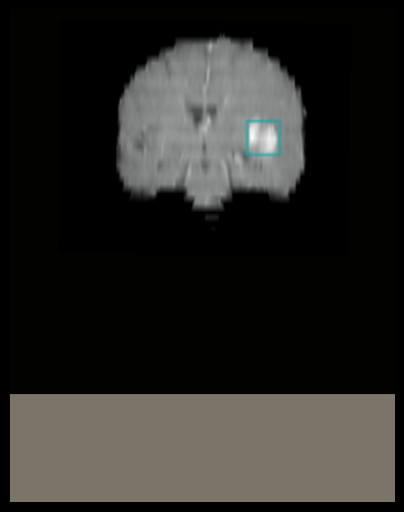

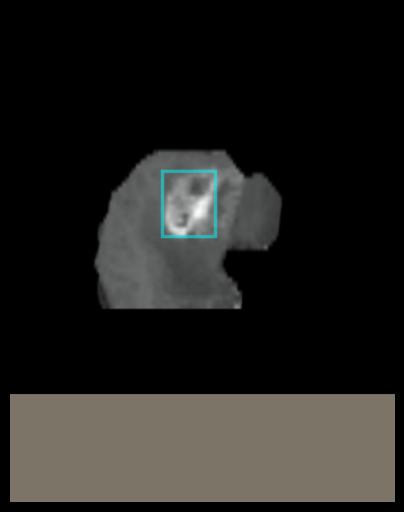

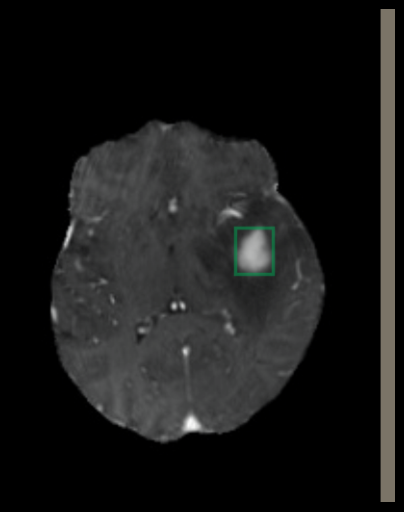

In [13]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
from detectron2.utils.visualizer import Visualizer

for i,item in enumerate(images.tensor[:3]):
    img = np.moveaxis(item.to("cpu").numpy(),0,-1)
    pixel_mean= cfg.MODEL.PIXEL_MEAN
    pixel_std = cfg.MODEL.PIXEL_STD
    img = (img*pixel_std) + pixel_mean
    v = Visualizer(img,metadata={},scale=0.5)
    v = v.overlay_instances(boxes=data[i]["instances"].get("gt_boxes"))
    dpi = 80
    im_data = v.get_image()[:,:,::-1]
    height,width,depth = im_data.shape
    figsize = width/float(dpi),height/float(dpi)
    fig = plt.figure(figsize=figsize)
    plt.imshow(im_data)
    plt.imshow(im_data)
    plt.axis("off")
    plt.show()
    

- Examples of preprocessed images and labels before feeding to the backbone 
- smaller images in a batch are padded to have the maximum size, and all images have the same size.
- Bouding boxes are also scaled accordingly 
## Sample images
After understanding how Detectron2 preprocesses input images and ground-truth boxes,we can now sample for several iterations,get the ground-truth bounding boxes from this set,and analyze them to get the right sizes and ratios for training 

In [14]:
from tqdm import tqdm
import torch
def get_gt_boxes_bacth(data):
    gt_boxes =[item['instances'].get('gt_boxes').tensor for item in data ]
    return torch.concat(gt_boxes)
def get_gt_boxes(trainer,iterations):
    trainer._data_loader_iter = iter(trainer.data_loader)
    gt_boxes = [get_gt_boxes_bacth(next(trainer._data_loader_iter)) for _ in tqdm(range(iterations))]
    return torch.concatenate(gt_boxes)
gt_boxes = get_gt_boxes(trainer,1000)
print()
print(gt_boxes.shape)
    
    

100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]


torch.Size([6319, 4])


- This code snippet should give us a tensor of bounding boxes. Each bounding box is in the format (x1,y1,x2,y2) for the top-left and lower-right corners of the bounding box while analyzing the anchors and the bounding boxes,we use width and height information rather than minimum and maximum coordinates. 
- The following code snippet converts the coordinates into width and height coorespondingly and quickly looks at their minimum and maximum edge sizes

In [15]:
def boxes2wh(boxes):
    x1y1 = boxes[:,:2]
    x2y2 = boxes[:,2:]
    
    return x2y2 - x1y1
gt_wh = boxes2wh(gt_boxes)
print(gt_wh.min(),gt_wh.max()) #! minimum and maximum edge sizes of all the ground-truth boxes 

tensor(22.3098) tensor(299.3030)


In [16]:
print("Sizes",cfg.MODEL.ANCHOR_GENERATOR.SIZES)
print("ratio",cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS)

Sizes [[32], [64], [128], [256], [512]]
ratio [[0.5, 1.0, 2.0]]


- We use a Feature Pyramid Network (FPN) as the backbone,so the anchor sizes are for different layers.
That explains the second dimension for the array of anchor sizes. if we don't use FPN, the size should look like [32,64,128,256,512] instead. 
- The following code snippets uses Detectron2's Default anchor generator to generate a set of anchors from the previous set of sizes and ratios and converts them into widths and heights correspondingly:

In [17]:
generate_anchors = trainer.model.proposal_generator.anchor_generator.generate_cell_anchors
anchors = generate_anchors()
ac_wh = boxes2wh(anchors)

after having the ground-truth boxes and methods to generate anchors,we are ready to analyze the training bounding boxes and propose a set of initial sizes and ratios that better fit the training data 
# Generating sizes and ratios hyperparameters 
The ground-truth boxes and anchors are currently in the width and height format, while we need to
analyze them in sizes and ratios. Therefore, the following code snippet creates two methods and uses
them to convert ground-truth widths and heights into sizes and ratios:


In [18]:
def wh2size(wh):
    return torch.sqrt(gt_wh[:,0]*gt_wh[:,1])
def wh2ratio(wh):
    return wh[:,1]/wh[:,0]
gt_sizes = wh2size(gt_wh)
gt_ratios = wh2ratio(gt_wh)


#### Generally, the algorithm to get the best set of sizes and ratios for training has the following steps:
1.Quantify how well each ground-truth box matches a set of anchors (compute best ratios).

2.Quantify the fitness between the set of ground-truth boxes, as a whole, and the set of anchors (compute a fitness score).

3.Perform clustering algorithms on the ground-truth sizes and ratios and get the initializations for these two sets of parameters.

4.Use a genetic algorithm to randomly evolve and get a good set of sizes and ratios for the training process.

## Compute the best ratios 
For each ground-truth bounding box, there must be a method to quantify how well it can fit with
the set of given anchors. We divide the width and height of the ground-truth box by each anchor’s
width and height and take the inversion. Taking the inversion is necessary because these two boxes’
differences are symmetric (two-way). For each anchor, we take the worst ratio to indicate fitness (i.e.,if there are suitable matches and bad matches, we will take the worst match as the measure of fitness).

On the other hand, for each ground-truth box, we do not need all the anchors to match well, and it is
enough to have at least one anchor that fits well with it. Therefore, we take the maximum ratio among
the ratios generated for all anchors as a fitness ratio. This ratio is the indicator of the fitness of this
one ground-truth box with the set of anchors

In [19]:
def best_ratio(ac_wh,gt_wh):
    """
    the function calculates all possible aspect ratios by dividing each ground truth height by each predicted width.
    The [:,None] and [None] synatx is used to broadcast the dimensions of the two arrays so that they can be divided element-wise. 
    The result is a 2D array of shape(num_gt,num_ac)
    """
    all_ratios = gt_wh[:,None]/ac_wh[None]
    inverse_ratios = 1/all_ratios
    # takes the element-wise minimuma and maximum -1 specifies that min/max should be taken along the last dimension(predicted boxes)
    ratios = torch.min(all_ratios,inverse_ratios)
    worst = ratios.min(-1).values
    best = worst.max(-1).values
    
    return best

This function helps quantify the fitness of individual ground-truth boxes with a set of anchors and returns  a list of fitness ratios. 
## Quantify the fitness
One approach is to take the average of all the fitness score for all the ground-truth boxes as one fitness score between a set of ground-truth boxes as  a whole,given a set of anchors. 


In [20]:
def fitness(ac_wh,gt_wh,EDGE_RATIO_THRESHOLD=0.25):
    """
    the default threshold value is 0.25, which means that if the ratio of any side of two boxes differs by more than four times,they are considered bad matches 
    """
    ratio = best_ratio(ac_wh,gt_wh)
    ret = (ratio*(ratio>EDGE_RATIO_THRESHOLD).float()).mean()    
    return ret


In [21]:
def best_recall(ac_wh,gt_wh,EDGE_RATIO_THRESHOLD=0.25):
    ratio = best_ratio(ac_wh,gt_wh)
    best = (ratio>EDGE_RATIO_THRESHOLD).float().mean()
    return best 

a ground truth box with edges that don't exceed four times or are not smaller than four times the size of at least one anchor is then recallable. 

In [22]:
print("recall",best_recall(ac_wh,gt_wh))
print("fitness",fitness(ac_wh,gt_wh))

recall tensor(1.)
fitness tensor(0.7831)


These results indicate that this default set of hyperparameters is relatively good for this case,However it's possible to use a genetic algorithm to improve fitness. 
### Using clustering algorithms 

In [23]:
import numpy as np 
from scipy.cluster.vq import kmeans
def estimate_clusters(values,num_clusters,iter=100):
    std = values.std(0).item()
    k,_ = kmeans(values/std,num_clusters,iter=iter)
    k *=std
    return k
def visualize_clusters(values,centers):
    plt.hist(values,histtype="step")
    plt.scatter(centers,[0]*len(centers),c="red")
    plt.show()

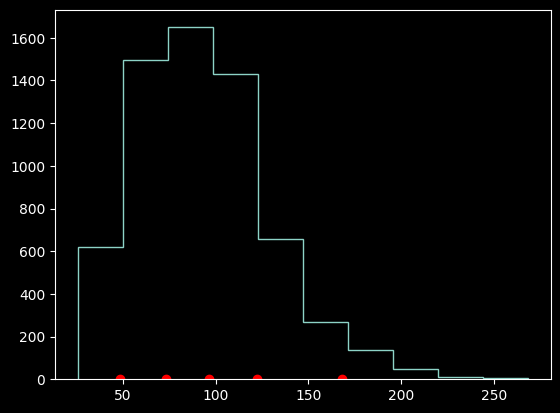

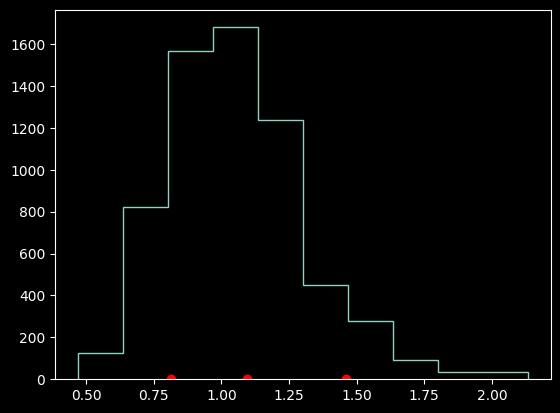

In [24]:
sizes = estimate_clusters(gt_sizes,5)
visualize_clusters(gt_sizes,sizes)
ratios = estimate_clusters(gt_ratios,3)
visualize_clusters(gt_ratios,ratios)


Most sizes are 100 pixels, and the ratios are more toward 1.0 because most boxes are square. 


In [25]:
fitness(boxes2wh(generate_anchors(sizes,ratios)),gt_wh)

tensor(0.8784, dtype=torch.float64)

This score is a much better fit than the default anchor set we can improve it with genetic algorithm
## Evlovle the results using the genetic algorithm 
1. start with the initial sizes and ratios generated by the clustering algorithms 
2. sample some items to evolve based on a given probability (eg. 0.9 have an item evolve 90% of the time)
3. sample some random evolving amounts from a normal distribution  with a given mean and standard deviation 
4. Change the sizes and ratios using the generated random amounts
5. compute a fitness score using the new sets of sizes and ratios 
6. If the fitness improves, set the initial set of sizes and ratios to these current sets and loop back to step 1 otherwise,proceed to step 2 

In [26]:
def evolve(sizes,ratios,gt_wh,iterations=10000,probability=0.9,muy=1,sigma=0.05,fit_fn=fitness,verbose=False):
    anchors = generate_anchors(tuple(sizes),tuple(ratios))
    ac_wh = boxes2wh(anchors)
    best_fit = fit_fn(ac_wh,gt_wh)
    anchor_shape = len(sizes) + len(ratios)
    
    pbar = tqdm(range(iterations),desc=f"Evolving ratios and sizes:")
    for i, _ in enumerate(pbar):
        #to mutate and how much 
        mutation = np.ones(anchor_shape)
        mutate = np.random.random(anchor_shape)<probability
        mutation = np.random.normal(muy,sigma,anchor_shape)*mutate 
        mutation = mutation.clip(0.3,3.0)
        #mutated 
        mutated_sizes = sizes.copy()*mutation[:len(sizes)]
        mutated_ratios = ratios.copy()*mutation[-len(ratios):]
        mutated_anchors = generate_anchors(
            tuple(mutated_sizes),
            tuple(mutated_ratios)
        )
        mutated_ac_wh = boxes2wh(mutated_anchors)
        mutated_fit = fit_fn(mutated_ac_wh,gt_wh)
        
        if mutated_fit>best_fit:
            sizes = mutated_sizes.copy()
            ratios = mutated_ratios.copy()
            best_fit = mutated_fit
            pbar.desc=(f"Evolving ratios and sizes, Fitness = {best_fit:.4f}")
    return sizes,ratios

In [27]:
e_sizes, e_ratios = evolve(sizes, ratios, gt_wh, verbose=False)


Evolving ratios and sizes, Fitness = 0.8845: 100%|██████████| 10000/10000 [00:24<00:00, 400.47it/s]


In [28]:
print("sizes",e_sizes)
print("ratios",e_ratios)

sizes [ 86.74344385 111.15039289 144.6967493   64.91778448  43.43608345]
ratios [0.99055315 0.78273349 1.24811079]


In [29]:
## Therefore the trainign configuration should use the following hyperparameters for sizes and ratios 
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [e_sizes[0],e_sizes[1],e_sizes[2],e_sizes[3]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [ e_ratios[0],e_ratios[1],e_ratios[2]]

## Settnig pixel means and standard deviations 
Input image pixel's and standard deviations are crucial in traingin Detectron2 Models,
he uses these valeus to normalize the input images,
The common values for these two hyperparameters generated from the ImageNet dataset are [103.53,116.28,123.675] and
[57.375,57.120,58.395]. 
These values are appropariate for  most of the color images. However,this specific case has grayscale images with different values for pixel mean and standard deviations.
Therefore, producing these two sets of values from the training
dataset would be beneficial. This task has two main stages: (1) preparing a data loader to load images and (2) creating a class to calculate running means and standard deviations.



# Preparing a data loader 


In [30]:
from tqdm import tqdm
import torch 
from torch.utils.data import Dataset,DataLoader
import os 
import cv2
name_ds = "braintumors_coco"
af = "_annotations.coco.json"
img_dir = name_ds + "/train/"
json_file_train = name_ds + "/train/" + af 
batch_size = 64
num_workers= 2 

In [31]:
class TumorDataset(Dataset):
    def __init__(self,data,img_dir="",transform=None):
        self.data = data 
        self.img_dir = img_dir 
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        file_name = os.path.join(self.img_dir,self.data[idx]["file_name"])
        image = cv2.imread(file_name)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image 

In [33]:
import albumentations as A 
from albumentations.pytorch import ToTensorV2

image_size  =640
augs = A.Compose([
    A.Resize(height=image_size,width=image_size),
    ToTensorV2()
])


In [36]:
import json 
with open(json_file_train) as f:
    ds = json.load(f)['images']
tds = TumorDataset(ds,img_dir = img_dir,transform=augs)
image_loader = DataLoader(tds,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=num_workers,
                          pin_memory=True)

## Calculate running means and standard deviations 

In [37]:
def broad_cast(x,image_size,channel):
    y = torch.broadcast_to(x,(image_size**2,channel))
    z = y.reshape(image_size,image_size,3)
    return torch.moveaxis(z,2,0)

In [43]:

class RunningStats:
  def __init__(self):
    self.n = 0
    self.mean = 0
    self.ssd = 0 
    
  def push(self, x):
    # start
    dims = [0, 2, 3]
    count = 1
    for dim in dims:
      count *= x.shape[dim]
    image_size = x.shape[-1]
    channel = x.shape[1]
    if self.n == 0:
      # start
      new_mean = x.sum(axis=dims)/count
      new_ssd = ((
          x - broad_cast(
                new_mean, 
                image_size, 
                channel
                ))**2).sum(axis=dims)
      new_count = count
    else:
      # old
      old_count = self.n
      old_mean = self.mean
      old_ssd = self.ssd
      old_sum = old_mean * old_count      
      # new
      new_count = self.n + count
      new_sum = old_sum + x.sum(axis=dims)
      new_mean = new_sum/(self.n + count)
      
      old_ssd_new_mean = (
          old_ssd  
          + 2*old_mean*old_sum
          - old_count*(old_mean)**2
          - 2*new_mean*old_sum
          + old_count*(new_mean)**2
          )
      
      new_ssd = (
          old_ssd_new_mean + 
          (
              (x - broad_cast(new_mean, 
                           image_size, 
                           channel))**2
           ).sum(axis=dims))
    # release results
    self.mean = new_mean
    self.ssd = new_ssd
    self.n = new_count
    self.std = torch.sqrt(new_ssd/(new_count-1))

In [46]:
rs = RunningStats()
for inputs in tqdm(image_loader):
    rs.push(inputs)
print(rs.mean)
print(rs.std)

100%|██████████| 14/14 [00:10<00:00,  1.28it/s]

tensor([20.1962, 20.1962, 20.1962])
tensor([39.5985, 39.5985, 39.5985])
